Code example showing how to turn a NuSTAR evt file into a lightcurve using code from the [NuSTAR PySolar Repo](https://github.com/NuSTAR/nustar_pysolar)

**Tested to work with SunPy v3.1 and the corresponding version of NuSTAR_pysolar**

Using, evt and hk file in this repo

In [1]:
import sys
from os.path import *
import os

from astropy.io import fits
import astropy.units as u
import astropy.time
from astropy.timeseries import TimeSeries

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from pylab import figure, cm
from astropy.coordinates import SkyCoord

import numpy as np
import nustar_pysolar as nustar

%matplotlib inline

import warnings
warnings.simplefilter('ignore')
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [2]:
dirin=''
infile = 'nu90410111001A06_cl_sunpos.evt'
livefile = 'nu90410111001A_fpm.hk'

# Load in the evt file (has the list of photons)
hdulist = fits.open(dirin+infile)
evtdata=hdulist[1].data
hdr = hdulist[1].header
hdulist.close()

# Load in the hk file (has the livetime info)
hdulist = fits.open(dirin+livefile)
lvdata=hdulist[1].data
lvhdr = hdulist[1].header
hdulist.close()

In [3]:
# Convert times from sec relative to ref time into normal times
mjdref=astropy.time.Time(hdr['mjdrefi'],format='mjd')
tims=astropy.time.Time(mjdref+evtdata['time']*u.s,format='mjd')
# This is the time binning of the livetimes not the actual livetimes - which is lvdata['livetime']
ltims=astropy.time.Time(mjdref+lvdata['time']*u.s,format='mjd')

# Also pull out the actual livetimes (per 1s binning)
print(tims[0].iso,tims[-1].iso)
print(ltims[0].iso,ltims[-1].iso)

# Above could filter by energy or spatial region, before producing the list ofevents times
# Then would make lightcurve for some energy range, or region of interest, i.e.,
# cleanevt = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2., energy_high=5.0)
# Not much point here as short time range of quiet Sun data

2018-09-28 18:48:32.000 2018-09-28 18:50:12.986
2018-09-28 18:47:48.000 2018-09-28 18:50:14.000


In [4]:
# Use the 1sec time binning of the livetime for the binning of the counts
# And just work everything relative to the first livetime time bin
td=(tims-ltims[0]).sec
tdedgs=(ltims-ltims[0]).sec

In [5]:
# Use histogram to bin events to get number per 1s time bins
counts, bed=np.histogram(td,bins=tdedgs)
lvt=lvdata['livetime']
countrate=counts/lvt[:-1]

In [6]:
# Many ways of working with/plotting timeseries in python
# Here use astropy timeseries

ltc=TimeSeries(time=ltims[:-1].isot,\
               data={'livetime': lvt[:-1],'counts': counts,'countrate': countrate})

# Means that it is easy to save out the data, and load back in, i.e
ltc.write('ns_ltc.txt',format='ascii.csv',overwrite=True)
ltcn=TimeSeries.read('ns_ltc.txt',format='ascii.csv',time_column='time',time_format='isot')

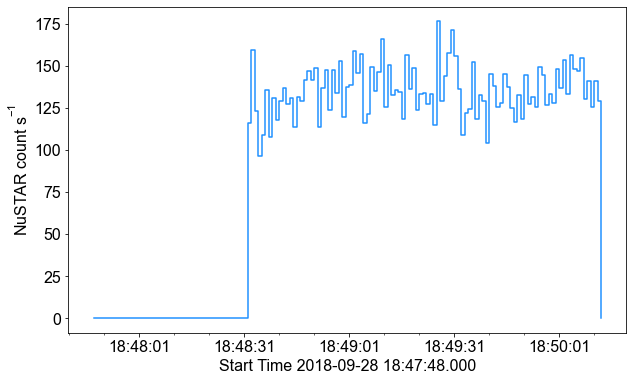

In [7]:
yr=np.array([1,500])

plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
fig,ax= plt.subplots(figsize=(10, 6))

plt.plot_date(ltcn.time.datetime, ltcn['countrate'], drawstyle='steps-post',\
              marker=None,ls='solid',color='dodgerblue')

plt.ylabel('NuSTAR count s$^{-1}$')
plt.xlabel('Start Time '+ltcn.time[0].iso)
# If longer time range file then would want these to be MinuteLocator instead
ax.xaxis.set_major_locator(matplotlib.dates.SecondLocator(interval=30))
ax.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(interval=10))
# If longer time range file then maybe just '%H:%M'

myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
fig.show()

# Gap at the start as time range of livetime file longer than that of the evt

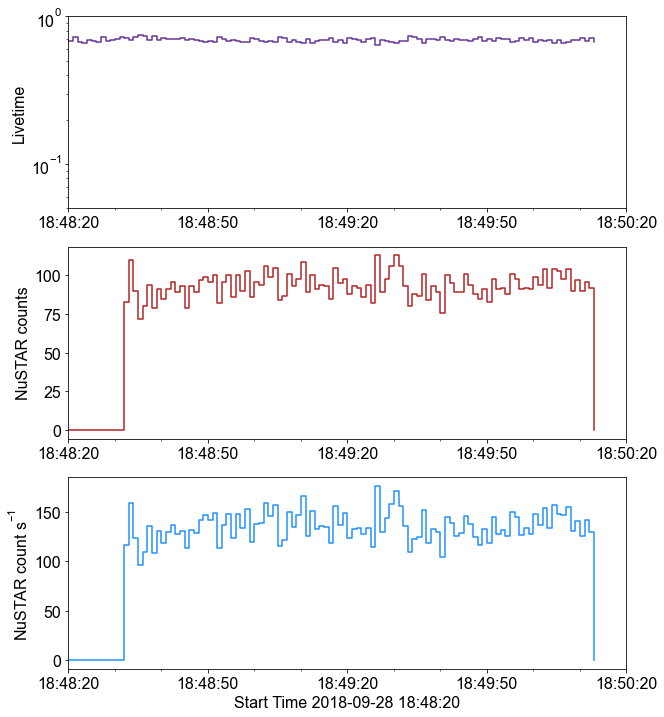

In [8]:
# Plot all 3 together, livetime, counts, countrat

# Set same time range for all plots
mint='2018-09-28 18:48:20'
maxt='2018-09-28 18:50:20'
tr=[matplotlib.dates.datestr2num(mint),matplotlib.dates.datestr2num(maxt)]
majorx=matplotlib.dates.SecondLocator(interval=30)
minorx=matplotlib.dates.SecondLocator(interval=10)
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')


fig= plt.figure(figsize=(10, 12))

ax0 = fig.add_subplot(311)
plt.plot_date(ltcn.time.datetime, ltcn['livetime'], drawstyle='steps-post',\
              marker=None,ls='solid',color='rebeccapurple')
ax0.set_ylabel("Livetime")
ax0.set_xlabel(" ")
ax0.set_xlim(tr)
# As plotting livetime this is always <1, as fraction in 1s bin
# This is very quiet, and so high livetime period, can get <1e-3 during bigger flares
ax0.set_ylim([5e-2,1])
ax0.set_yscale('log')
ax0.xaxis.set_major_locator(majorx)
ax0.xaxis.set_minor_locator(minorx)
ax0.xaxis.set_major_formatter(myFmt)

ax1 = fig.add_subplot(312)
plt.plot_date(ltcn.time.datetime, ltcn['counts'], drawstyle='steps-post',\
              marker=None,ls='solid',color='firebrick')
ax1.set_ylabel("NuSTAR counts")
ax1.set_xlabel(" ")
ax1.set_xlim(tr)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)

ax3 = fig.add_subplot(313)
plt.plot_date(ltcn.time.datetime, ltcn['countrate'], drawstyle='steps-post',\
              marker=None,ls='solid',color='dodgerblue')
ax3.set_ylabel("NuSTAR count s$^{-1}$ ")
ax3.set_xlabel("Start Time "+mint)
ax3.set_xlim(tr)
ax3.xaxis.set_major_locator(majorx)
ax3.xaxis.set_minor_locator(minorx)
ax3.xaxis.set_major_formatter(myFmt)

plt.show()

# Only a short time range (as brief mosaic pointing) and not much happening